In [187]:
warnings.filterwarnings("ignore")


NameError: name 'warnings' is not defined

# 0.0 Imports 

In [141]:
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
from matplotlib.gridspec     import GridSpec
import datetime
import inflection
from scipy                   import stats    as ss
import random                
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV
import xgboost               as xgb
import pickle
from flask                   import Flask
from IPython.display         import Image
import warnings
import reserchpy

ModuleNotFoundError: No module named 'xgboost'

### Loading data

In [2]:
df_sales_raw= pd.read_csv('train.csv',low_memory= False)
df_store_raw= pd.read_csv('store.csv',low_memory= False)

# Fazendo o merge dos dados para transformar os dois datasets em apenas 1 
df_raw=pd.merge(df_sales_raw,df_store_raw,how='left', on='Store')


In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
468060,546,4,2014-05-08,13992,1682,1,1,0,0,a,a,580.0,1.0,2005.0,0,NaN,NaN,NaN


### Descrição dos dados das variáveis

# 1.0 Descrição dos dados


### 1.1. Renomeando as colunas 

In [4]:
df1=df_raw.copy()  #criando uma copia do data para seguranca dos dados originais


In [5]:
df1.columns      #olhando os nomes das colunas

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase=lambda x:inflection.underscore(x) 
cols_new=list(map(snakecase,cols_old))  #lambda: e a declaracao de uma funcao 
#snakecase: reencreve em minusculo e com _ como separador
#funcao map: faz o mapeamento da funcao snakecase em todas as palavras da lista cols_old

#Rename
df1.columns=cols_new


### 1.2 Dimensao dos dados

In [7]:
print('Numbers of Rows:{}'.format(df1.shape[0])) 
print('Numbers of Columns:{}'.format(df1.shape[1]))

Numbers of Rows:1017209
Numbers of Columns:18


### 1.3. Tipo de dados 

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date']=pd.to_datetime(df1['date'])  # ajustando a variavel de data 



### 1.4 Checando os NAs

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Preenchendo os NAs

In [188]:

#competition_distance (Na's faltantes:  2642 )

df1['competition_distance']=df1['competition_distance'].apply(lambda x:2000000.0 if math.isnan(x) else x)
# distancia em metros do competidor mais proximo . 
# math.isnam : encontra na coluna os valores sem dados 



In [12]:
df1['competition_distance'].max()

2000000.0

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [14]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
956617,733,7,2013-02-24,12419,2814,1,0,0,0,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN


In [15]:

#nao possui competidor proximo ou nao tem o dado
#No entendimento assumo que : se tiver dados vazios(isnan.math) na coluna 'competition since mounth/year/week', eu vou pegar a coluna 'date' extrair o mes e substituindo o NA, aplicando(apply)em todas as colunas (axis 1)
    
#competition_open_since_month (Na's faltantes: 323348)
#mes e ano que o competidor abriu 
df1['competition_open_since_month']=df1.apply(lambda x:x ['date'].month if math.isnan (x['competition_open_since_month'])else x ['competition_open_since_month'],axis=1)

#competition_open_since_year   ( Na's faltantes:  323348)
df1['competition_open_since_year']=df1.apply(lambda x:x ['date'].year if math.isnan (x['competition_open_since_year'])else x ['competition_open_since_year'],axis=1)

#promo2_since_week             ( Na's faltantes:  508031)
df1['promo2_since_week']=df1.apply(lambda x:x ['date'].week if math.isnan (x['promo2_since_week'])else x ['promo2_since_week'],axis=1)

#promo2_since_year             ( Na's faltantes:  508031)
df1['promo2_since_year']=df1.apply(lambda x:x ['date'].year if math.isnan (x['promo2_since_year'])else x ['promo2_since_year'],axis=1)

#promo_interval                  508031
#crio uma lista de meses, se a data estiver dentro da lista a promo2 foi ativa.

month_map={1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0,inplace=True) #fillna na coluna promo_interval com valor 0, #inplace=true para nao retornar nada, com modificacao direto na coluna 

df1['month_map']=df1['date'].dt.month.map(month_map) # substituindo os dados da coluna date para os meses da lista month map
df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']==0 else 1if x['month_map']in x['promo_interval'].split(',')else 0, axis=1)                                      



In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [17]:
df1.sample(5).T

,873776,854836,785505,432650,736262
store,402,417,216,816,33
day_of_week,4,7,6,1,1
date,2013-05-09 00:00:00,2013-05-26 00:00:00,2013-07-27 00:00:00,2014-06-09 00:00:00,2013-09-09 00:00:00
sales,0,0,5161,0,12108
customers,0,0,646,0,1063
open,0,0,1,0,1
promo,0,0,0,0,1
state_holiday,a,0,0,a,0
school_holiday,0,0,0,0,0
store_type,c,a,c,c,a


### 1.6 Change types


In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)
df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

### 1.7 Descrição estatística 

In [20]:
# separando as variaveis numericas e as categoricas 
num_attributes= df1.select_dtypes(include=['int64','float64'])
cat_attributes= df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [21]:
num_attributes.sample(2)


,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
905631,1037,4,7057,956,1,1,0,150.0,4,2013,0,15,2013,0
666038,54,1,5404,531,1,0,0,7170.0,8,2014,1,5,2013,1


In [22]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
727884,0,a,a,"Jan,Apr,Jul,Oct",Sep
13791,0,d,c,"Jan,Apr,Jul,Oct",Jul


### 1.7.1 Numéricos

In [23]:
# central tendency- mean, median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T
#Dispersion- std,min,max,range,skew,kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T
#concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=(['attributes','min','max','range','mean','median','std','skew','kurtosis'])


In [24]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


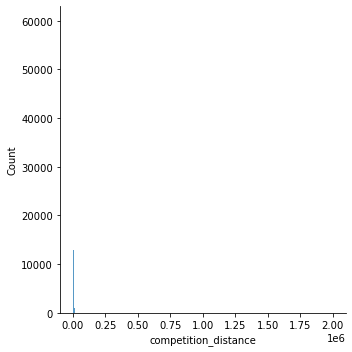

In [25]:
sns.displot(df1['competition_distance'])

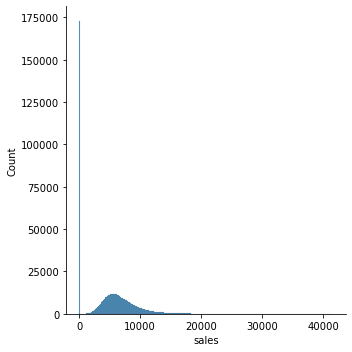

In [26]:
sns.displot(df1['sales'])

### 1.7.2 Categóricos

In [27]:
cat_attributes.apply(lambda x:x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

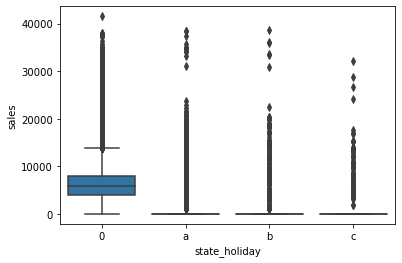

In [28]:
# box plot : formula: sns.boxplot( x= 'nome da categoria', y= 'objeto a ser medido', data= 'dados do data frame ou lista')
sns.boxplot(x='state_holiday',y='sales', data= df1)


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

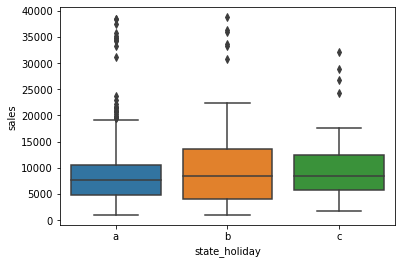

In [29]:

aux1=df1[(df1['state_holiday']!='0')& (df1['sales']>0)]
sns.boxplot(x='state_holiday',y='sales', data= aux1)


<AxesSubplot:xlabel='assortment', ylabel='sales'>

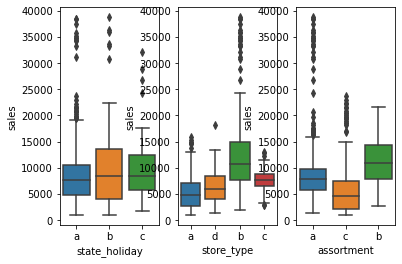

In [30]:
aux1=df1[(df1['state_holiday']!='0')& (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)


# 2.0 Feature engineering

### 2.1 Mapa das hipóteses 

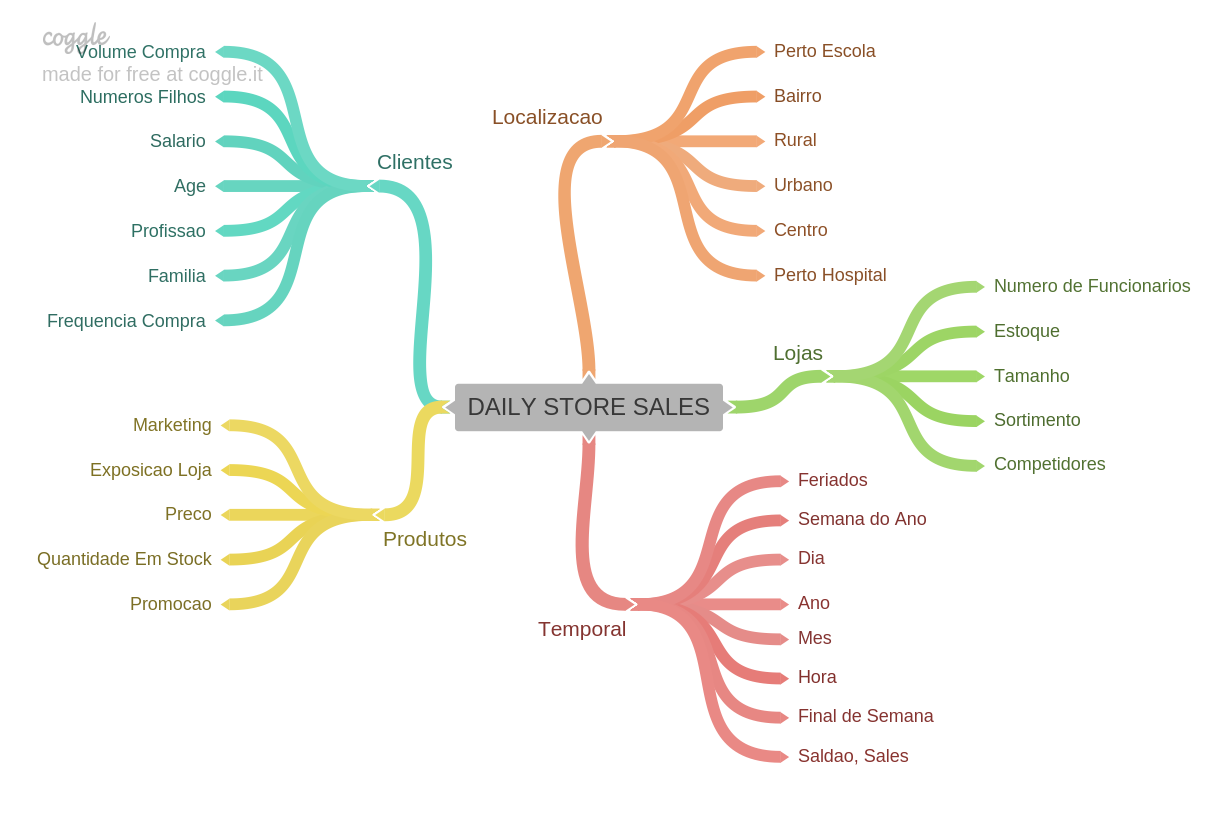

In [31]:
Image('MindMapHypothesis.png') # ferramenta coggle


### 2.2 Criação de hipóteses 

#### 2.2.1 Hipóteses lojas

***1*** lojas com maior quadro de funcionarios deveriam vender mais

***2*** lojas com maior estoque deveriam vender mais

***3*** lojas com maior porte deveriam vender mais

***4*** lojas com maior sortimento deveriam vender mais

#### 2.2.2 Hipóteses Produtos

***1*** lojas que investem mais em marketing deveriam vender mais

***2*** lojas que expoem mais o produto deveriam vender mais

***3*** lojas que tem precos menores nos produtos deveriam vender mais

***4*** lojas que possuem precos menores por mais tempo deveriam vender mais


#### 2.2.3 Hipóteses Tempo

***1*** lojas que tem mais feriados deveriam vender mais

***2*** lojas que abrem nos primeiros 6 meses deveriam vender mais

***3*** lojas que abrem nos finais de semana deveriam vender mais

#### 2.2.4 Priorizaçao das hipóteses 

In [32]:
# Aquelas que já possuimos os dados 

***1*** lojas com maior sortimento deveriam vender mais

***2*** lojas com competidores mais proximos deveriam vender menos

***3*** lojas com competidores a mais tempos deveriam vender mais

***4*** lojas com promocoes ativas por mais tempos deveriam vender mais

***5*** lojas com mais dias de promocao deveriam vender mais 

***6*** lojas com mais promocoes consecutivas deveriam vender mais

***7*** lojas abertas durante os feriados deveriam vender mais

***8*** lojas deveriam vender mais ao longo dos anos

***9*** lojas deveriam vender mais no segundo semestre

***10*** lojas deveriam vender mais depois do dia 10 de cada mes

***11*** lojas deveriam vender menos aos finais de semana

***12*** lojas deveriam vender menos durante feriados escolares



In [33]:
df2=df1.copy()


### 2.3 Feature Engineering


In [34]:
#desmembrando da varivel "date" com a funcao dt.year
df2['year']=df2['date'].dt.year   
df2['month']=df2['date'].dt.month
df2['day']=df2['date'].dt.day
df2['week_of_year']=df2['date'].dt.weekofyear
df2['year_week']=df2['date'].dt.strftime('%Y-%W') 

#juntar as duas variaveis - competition since
df2['competition_since']=df2.apply(lambda x:datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month']=((df2['date']- df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

#promo since 
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(lambda x:datetime.datetime.strptime(x +'-1','%Y-%W-%w')- datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

##assortment 
df2['assortment']=df2['assortment'].apply(lambda x:'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#
df2['state_holiday']= df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c'else 'regular_day')


<ipython-input-34-52160331b8fa>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.weekofyear


In [35]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem dos dados

In [36]:
df3=df2.copy()
df3.head(15)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
5,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
6,7,5,2015-07-31,15344,1414,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
7,8,5,2015-07-31,8492,833,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27,0
8,9,5,2015-07-31,8565,687,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,681,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


## 3.1 Filtragem de linhas 

In [37]:
df3=df3[(df3['open']!=0)&(df3['sales']>0)]


## 3.2 Seleção de colunas 

In [38]:
cols_drop=['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop,axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [39]:
df4=df3.copy()



# 4.0 Análise exploratória de dados 

## 4.1 Análise Univariada 

### 4.1.1 Análise numérica 

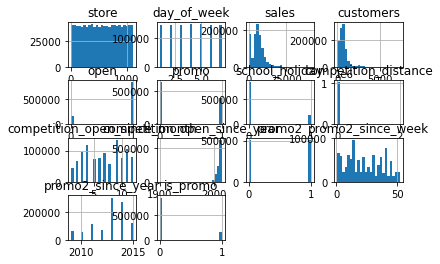

In [40]:
num_attributes.hist(bins=25);


### 4.1.2 Resposta da variável

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

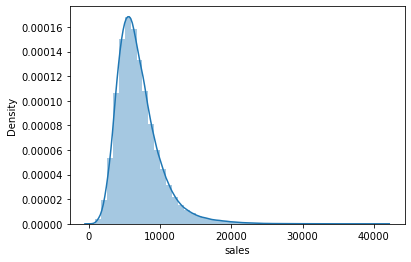

In [41]:
sns.distplot(df4['sales'])

<AxesSubplot:xlabel='sales', ylabel='Count'>

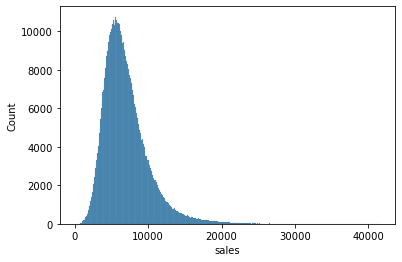

In [42]:
sns.histplot(df4['sales'])

### 4.1.3 Variavel Categórica

In [43]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [44]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

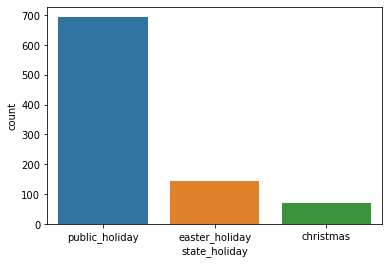

In [45]:
# state holiday
a=df4[df4['state_holiday']!= 'regular_day']
sns.countplot(a['state_holiday'])



/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

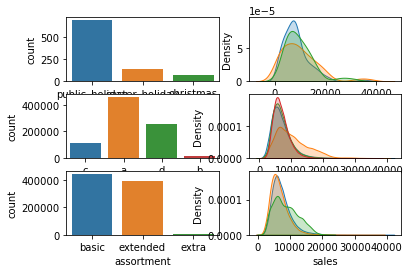

In [46]:
# state holiday + outros plots 


plt.subplot(3,2,1)
a=df4[df4['state_holiday']!= 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',shade=True)


#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',shade=True)


## 4.1 Análise Bivariada

***1*** lojas com maior sortimento deveriam vender mais

***2*** lojas com competidores mais proximos deveriam vender menos

***3*** lojas com competidores a mais tempos deveriam vender mais

***4*** lojas com promocoes ativas por mais tempos deveriam vender mais

***5*** lojas com mais dias de promocao deveriam vender mais 

***6*** lojas com mais promocoes consecutivas deveriam vender mais

***7*** lojas abertas durante os feriados deveriam vender mais

***8*** lojas deveriam vender mais ao longo dos anos

***9*** lojas deveriam vender mais no segundo semestre

***10*** lojas deveriam vender mais depois do dia 10 de cada mes

***11*** lojas deveriam vender menos aos finais de semana

***12*** lojas deveriam vender menos durante feriados escolares

## H1. Lojas com maior sortimento deveriam vender mais - Falsa



In [47]:
aux1= df4[['assortment','sales']].groupby('assortment').sum().reset_index()   # reset index gera um dataframe com possibilidade de alteracao 
#sns.barplot(x='assortment',y='sales',data=aux1);



KeyError: ('assortment',)

<Figure size 1080x720 with 0 Axes>

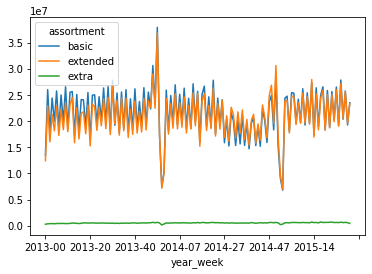

In [98]:
aux2= df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
plt.figure(figsize= (15, 10))


aux2.pivot(index='year_week',columns='assortment', values='sales').plot()
aux3= aux2[aux2['assortment',]=='extra']
aux3.pivot(index= 'year_week',columns= 'assortment', value='sales').plot();




## H2. Lojas com competidores mais próximos deveriam vender menos -Falsa



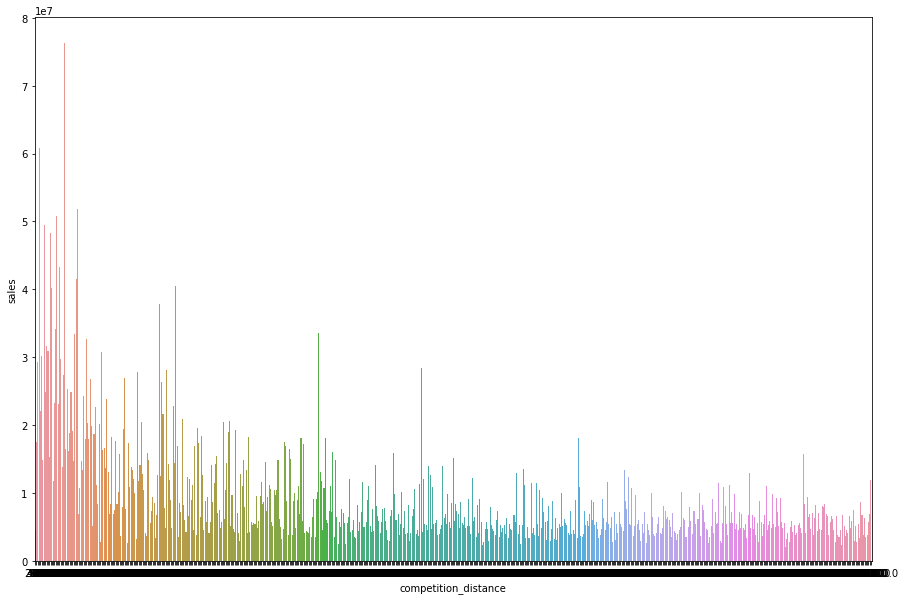

In [93]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize= (15, 10))
sns.barplot(x='competition_distance',y='sales',data=aux1);

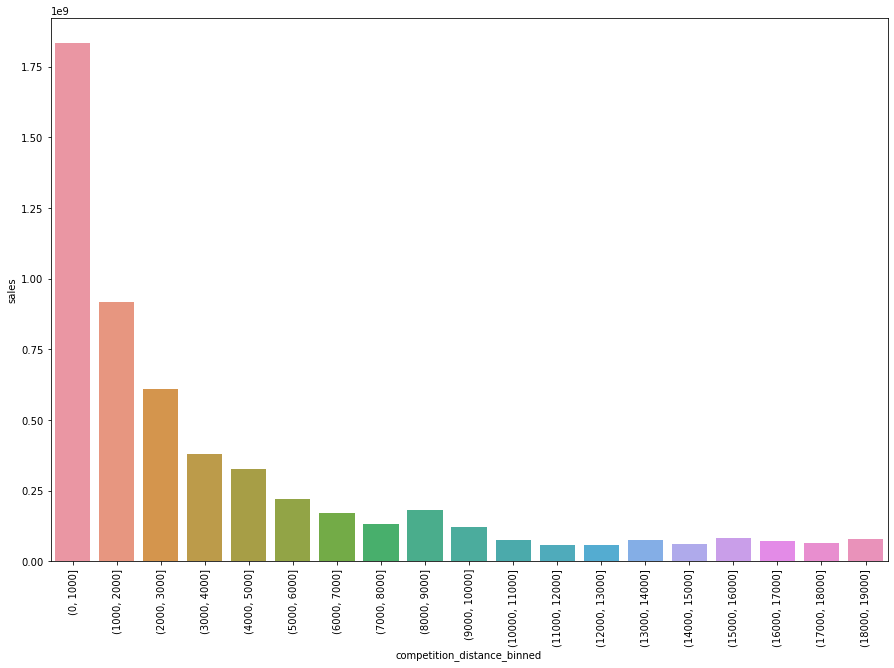

In [92]:
#ou com agrupamento(bin) para melhor visualizacao de 1000 em 1000.

aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize= (15, 10))


bins=list(np.arange(0,20000,1000)) #np.arrange= cria um array(lista de mesmo tipo)

aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins=bins) # cut= separa o valores da coluna 'comp_distance'no DataFrame df nas faixas etárias calculadas usando o valor do argumento bins no método pandas
aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()


sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90);




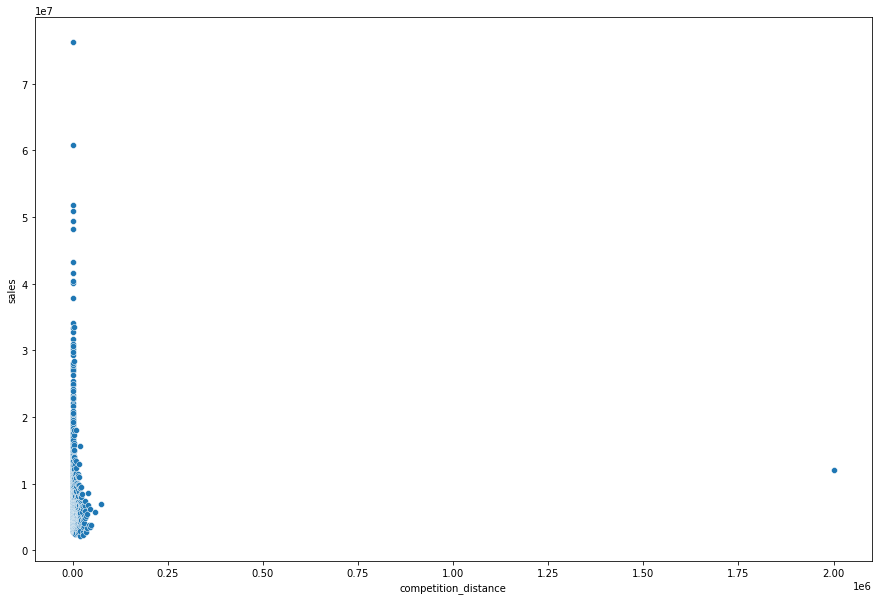

In [89]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize= (15, 10))

sns.scatterplot(x='competition_distance', y='sales',data=aux1);


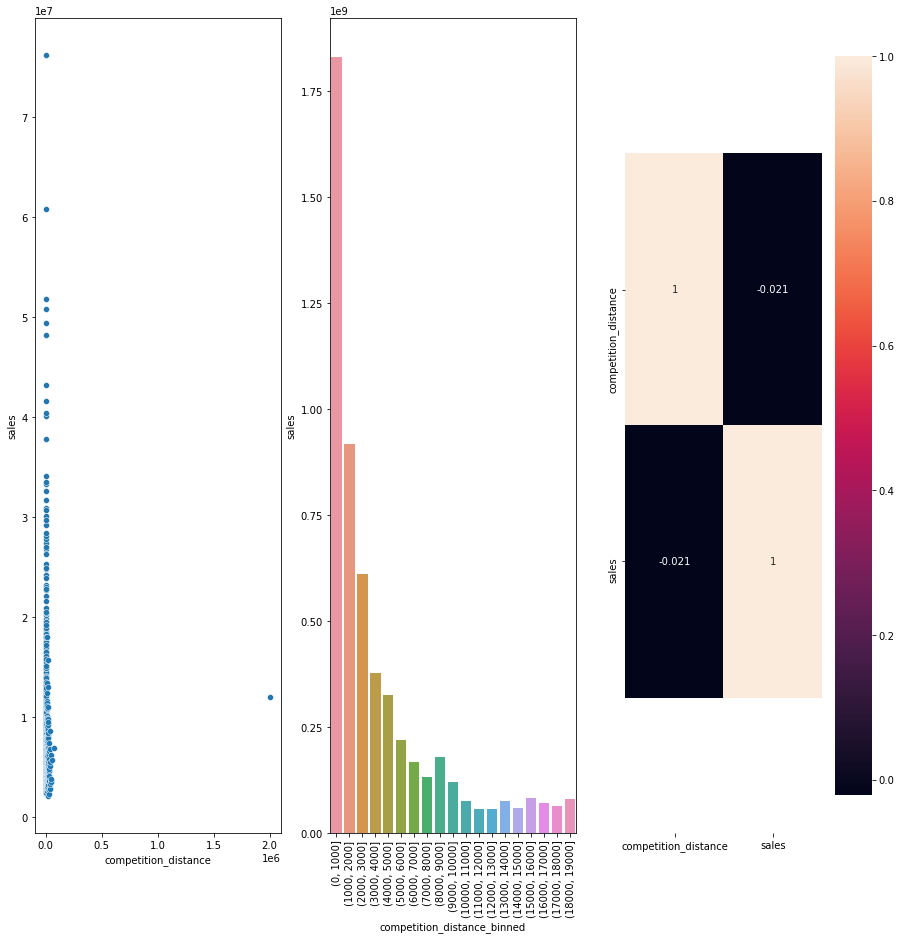

In [99]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize= (15, 15))

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales',data=aux1);

plt.subplot(1,3,2)
bins=list(np.arange(0,20000,1000)) #np.arrange= cria um array(lista de mesmo tipo)
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins=bins) # cut= separa o valores da coluna 'comp_distance'no DataFrame df nas faixas etárias calculadas usando o valor do argumento bins no método pandas
aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top=x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);


## H3.Lojas com competidores a mais tempo deveriam vender mais



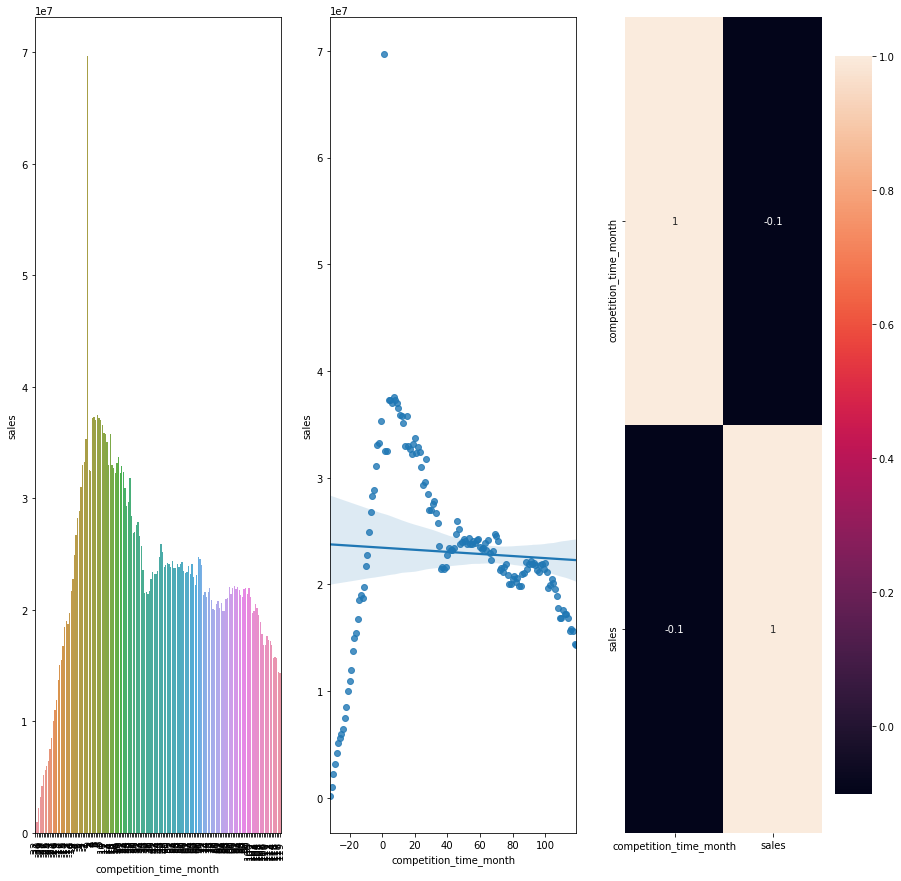

In [100]:
plt.figure(figsize= (15, 15))


plt.subplot(1,3,1)
aux1=df4[['competition_time_month','sales',]].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120)&(aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month',y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top=x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);




## H4. Lojas com promoçoes ativas por mais tempo deveriam vender mais



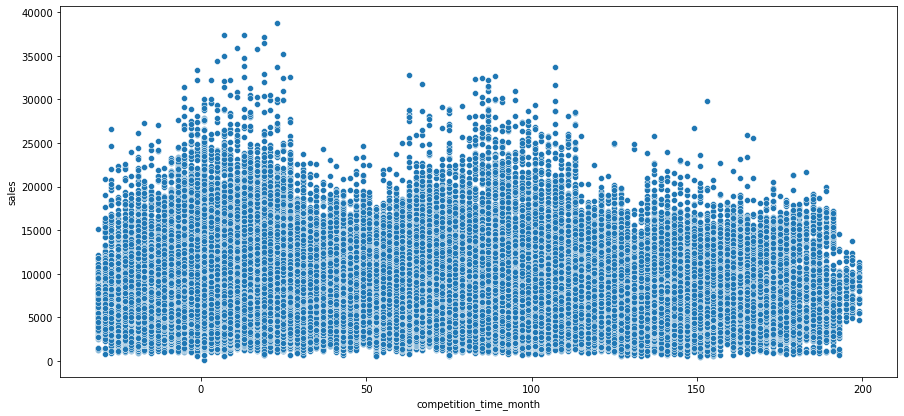

In [60]:
plt.figure(figsize= (15, 15))

plt.subplot(2,1,1)
sns.scatterplot(x= 'competition_time_month', y= 'sales', data= df4[(df4['competition_time_month'] <200) & df4['competition_time_month'] != 0])
titulo=('Tempo com Concorrência', 20);



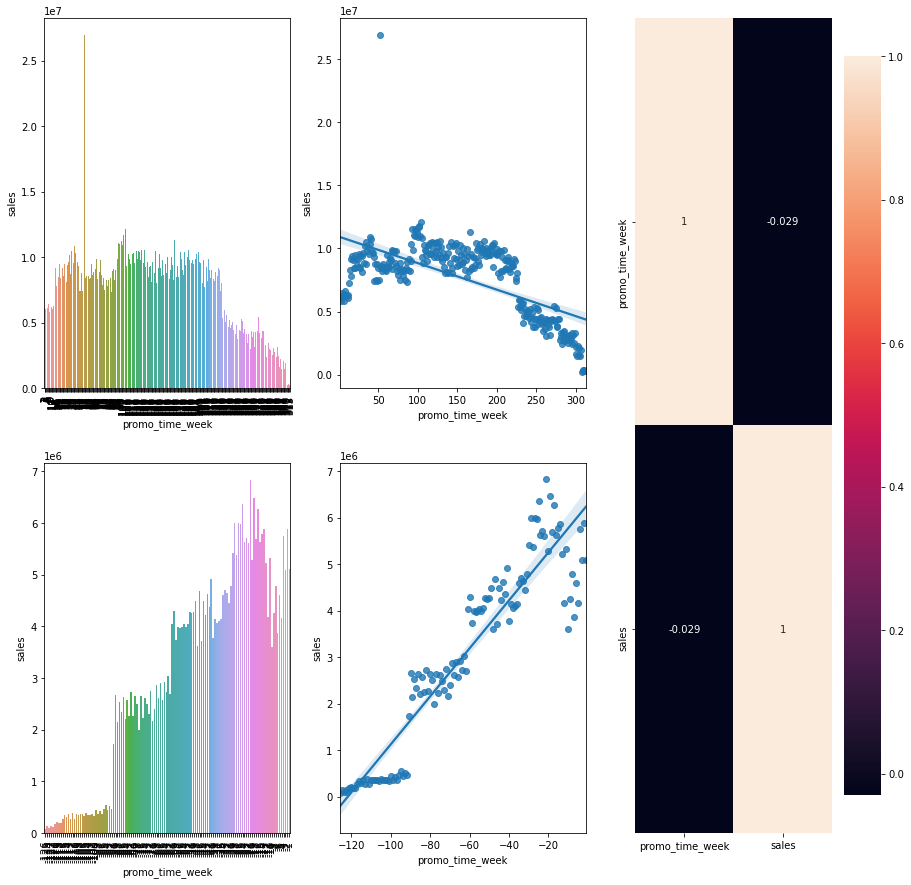

In [102]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize= (15, 15))

grid=GridSpec(2,3)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week']>0]
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90);


plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week']<0]
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);


##  H5. Lojas com mais promocoes consecutivas deveriam vender mais



In [105]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


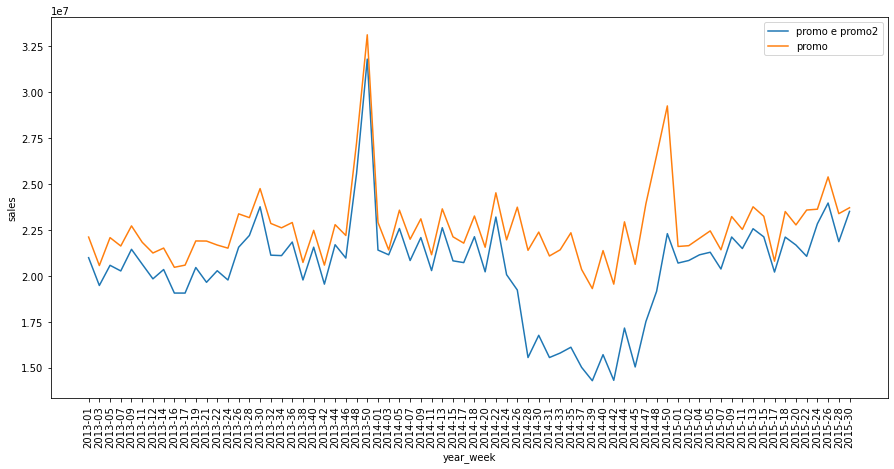

In [156]:
plt.figure(figsize= (15, 7))

aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['sales', 'year_week']].groupby('year_week').sum().reset_index()
sns.lineplot(x= 'year_week', y= 'sales', data= aux1, label= 'promo e promo2', estimator= sum)

aux2= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['sales', 'year_week']].groupby('year_week').sum().reset_index()
sns.lineplot(x= 'year_week', y= 'sales', data= aux2, label= 'promo', estimator= sum)
plt.xticks(rotation= 90);

## H6. Lojas que ficam abertas durante o feriado de Natal deveriam vender mais -False

<AxesSubplot:xlabel='year', ylabel='sales'>

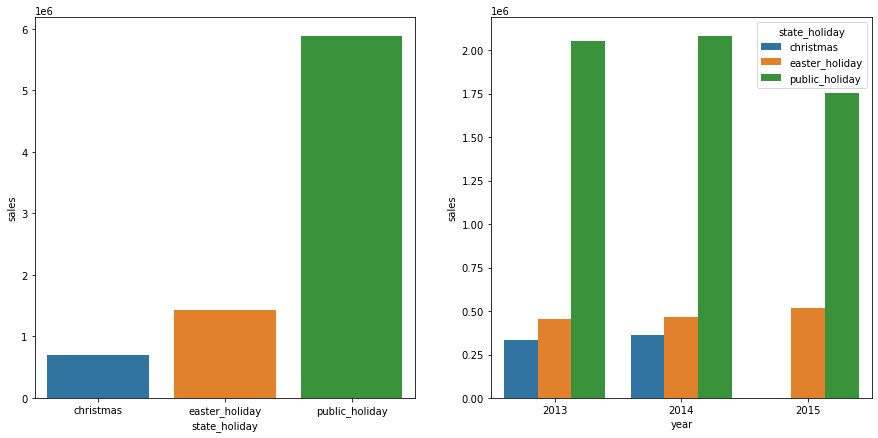

In [162]:
plt.figure(figsize= (15, 7))

plt.subplot(1,2,1)
aux=df4[df4['state_holiday']!='regular_day']
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);


plt.subplot(1,2,2)
aux2=aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2)



## H7. Lojas devem vender mais ao longo dos anos.

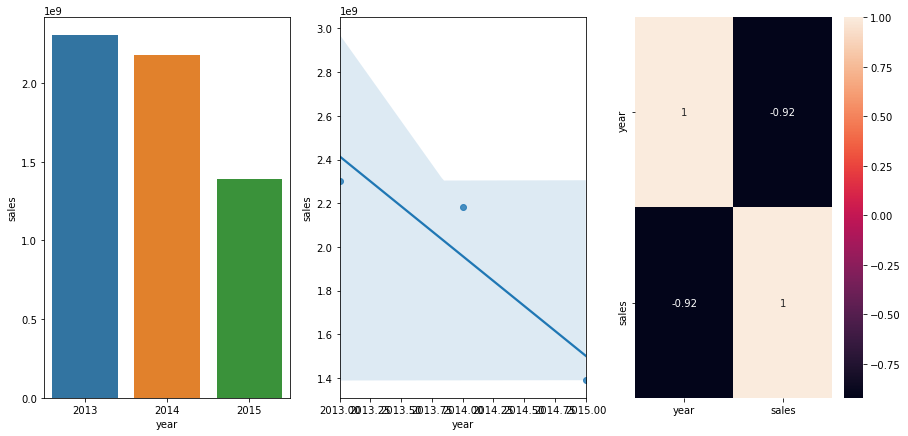

In [166]:
aux1= df4[['sales', 'year']].groupby('year').sum().reset_index()
plt.figure(figsize= (15, 7))

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data=aux1);
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


## H8. Lojas devem vender mais no segundo semestre do ano


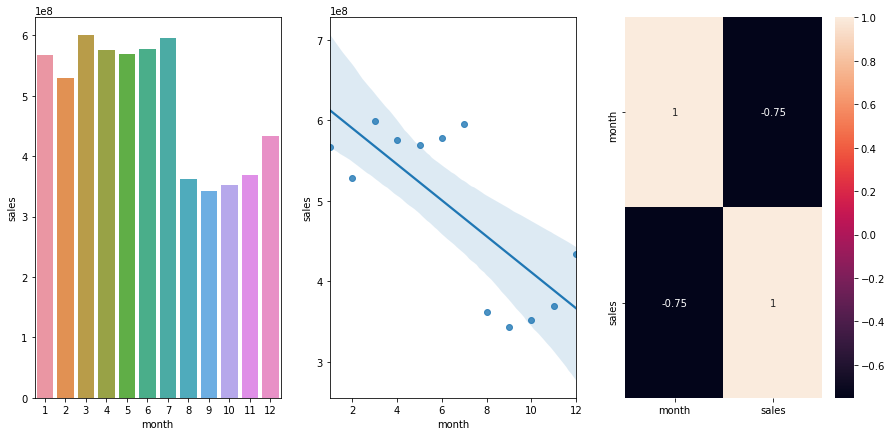

In [168]:
aux1= df4[['sales', 'month']].groupby('month').sum().reset_index()
plt.figure(figsize= (15, 7))

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## H9. Lojas vendem mais depois do dia 10 de cada mês - Verdadeira


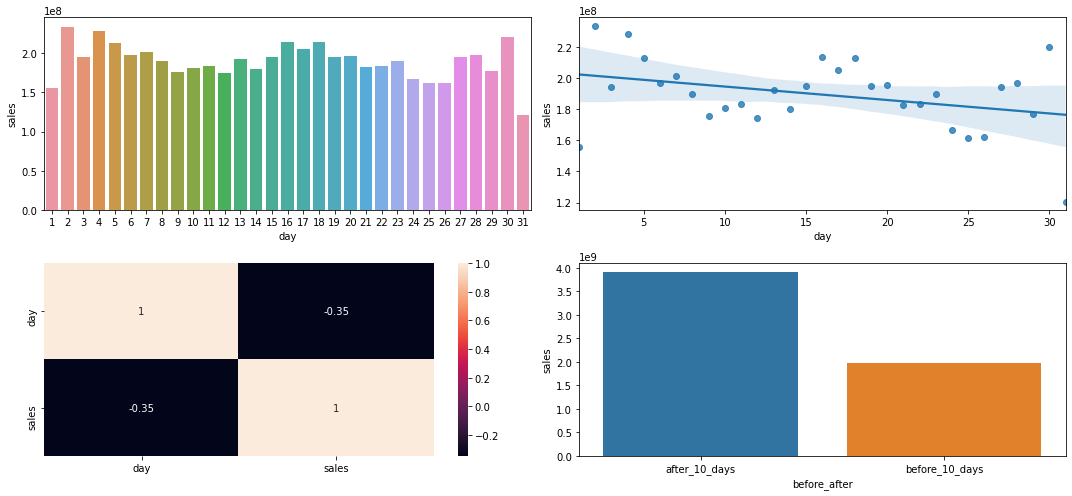

In [175]:
aux1= df4[['sales', 'day']].groupby('day').sum().reset_index()
plt.figure(figsize= (15, 7))

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']= aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby ('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales', data=aux2);
plt.tight_layout()




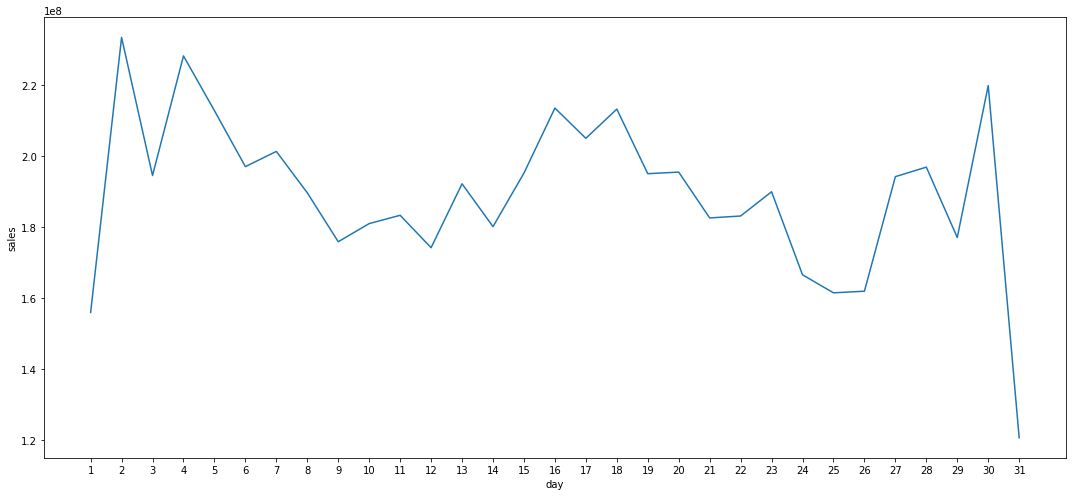

In [174]:
# gastos por dia do mes

aux1= df4[['sales', 'day']].groupby('day').sum().reset_index()
plt.figure(figsize= (15, 7))
sns.lineplot(x= 'day', y= 'sales', data= aux1, ci= None, estimator= sum)
plt.xticks(range(1,32));
plt.tight_layout()



## H10. Lojas deveriam vender menos no final de semana

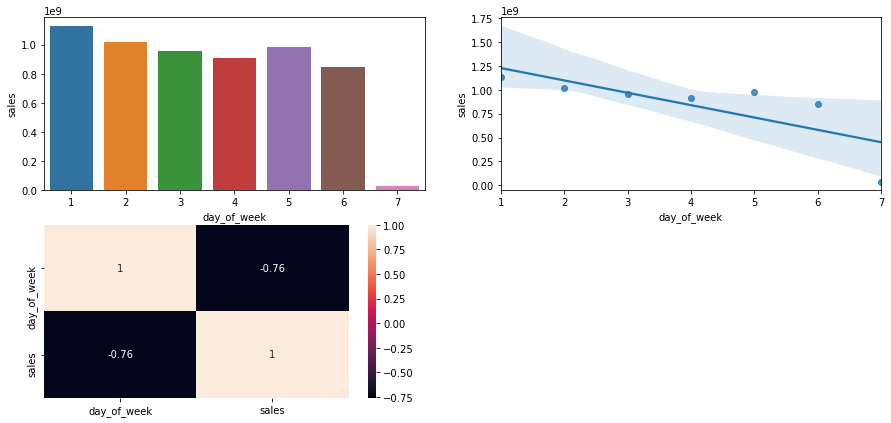

In [178]:
aux1= df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize= (15, 7))

plt.subplot(2,2,1)
sns.barplot(x='day_of_week',y='sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x='day_of_week',y='sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



## H11. Lojas devem vender menos nos feriados escolares.


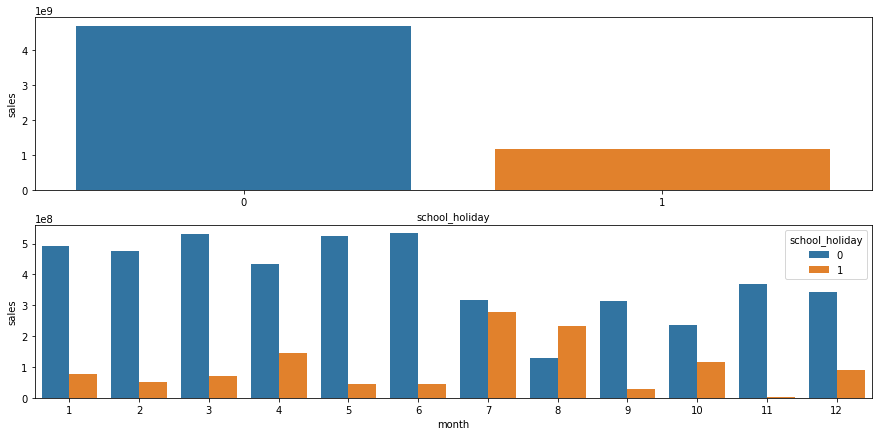

In [186]:
plt.figure(figsize= (15, 7))

aux1= df4[['sales','school_holiday']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2= df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);





## 4.3 Análise Multivariada 

## 4.3.1. Atributos Numéricos

<AxesSubplot:>

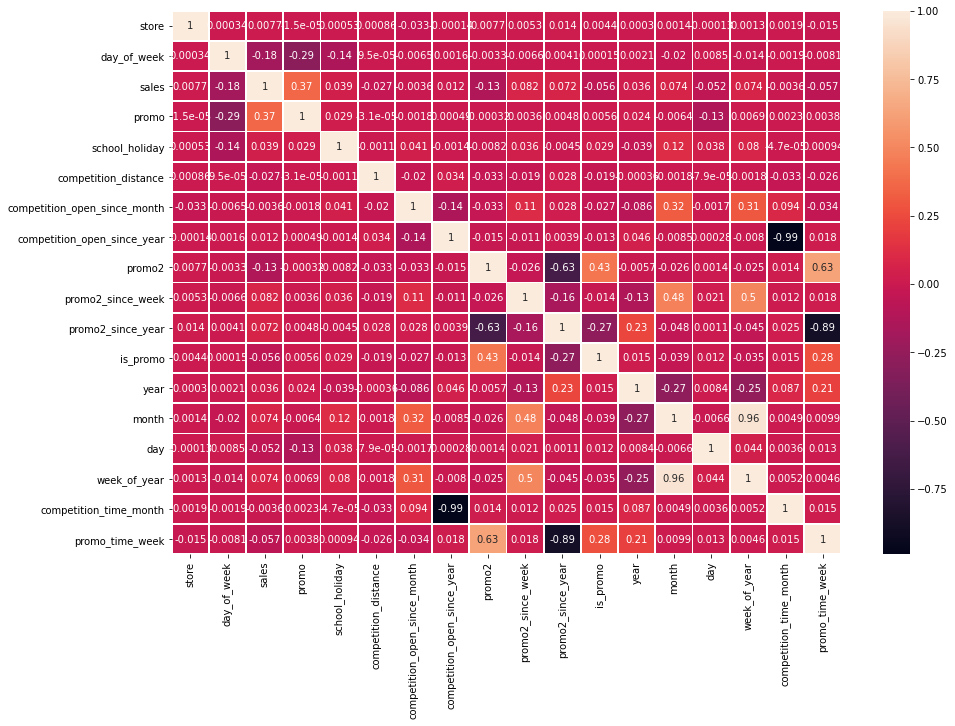

In [138]:
plt.figure(figsize= (15, 10))

sns.heatmap(df4.select_dtypes(include= ['float64', 'int64']).corr(), annot= True, linewidths= 1)

## 4.3.2. Atributos Categóricos

In [142]:
a= df4.select_dtypes(include= 'object')

a1= cramer_v(a['state_holiday'], a['state_holiday'])
a2= cramer_v(a['state_holiday'], a['store_type'])
a3= cramer_v(a['state_holiday'], a['assortment'])
a4= cramer_v(a['store_type'], a['state_holiday'])
a5= cramer_v(a['store_type'], a['store_type'])
a6= cramer_v(a['store_type'], a['assortment'])
a7= cramer_v(a['assortment'], a['state_holiday'])
a8= cramer_v(a['assortment'], a['store_type'])
a9= cramer_v(a['assortment'], a['assortment'])

d= pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d= d.set_index(d.columns)

plt.figure(figsize= (15, 7))
sns.heatmap(d, annot= True)
titulo('Matriz de Correlação - Variáveis Categóricas', 20);

NameError: name 'cramer_v' is not defined